Module : <b>Traitement d’images</b><br> Projet : <b>Reconnaissance faciale</b><br> Réalisé par : <b> Imad Anis KHEFFACHE & Hamza BERRABAH</b><br> Spécialité : <b>2DSIA</b>  <br> Année universitaire : <b>2022-2023</b><br>
# Réalisation d’un système de reconnaissance faciale <br>

# I. Approche :
Nous allons utiliser la base de données "Yalefaces" pour créer un système de reconnaissance faciale. Cette base de données contient 165 images de 15 personnes, chacune d'entre elles ayant été capturée dans 11 configurations faciales ou émotions différentes : lumière centrale, avec lunettes, heureux, lumière gauche, sans  lunettes, normal, lumière droite, triste, somnolent, surpris et clin d'œil. Les images ont une taille de 242x320 pixels.

#**NB. Les images utilisées dans ce Projet sont des images en niveaux de gris et de taille à l'entrée des modèles d'apprentissage égale à 242x320 pixels**

# II. Importation des librairies utilisées :

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmath
import os
import random
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold
from skimage import measure
from skimage.feature import hog
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# III. Pré-traitement :

## 1. Changement des noms des fichiers :
Ajout de l'extension .gif aux images

In [ ]:
chemin="drive/MyDrive/data_colab/yalefaces/"
for filename in os.listdir(chemin):
    original_name=chemin+filename
    new_name=chemin+filename+".gif"
    os.rename(original_name, new_name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Application de l’histogramme des profils :
L'histogramme des profils est une technique qui est faite pour isoler des motifs précis sur une image avec fond blanc, c'est une technique d'isolation qui est utilisée pour les images binaires ou binarisées.
L'application de cet histogramme nécessite d'abord une binarisation de l'image (noir et blanc) et un calcul de 2 histogrammes un pour les lignes et l'autre pour les colonnes.

### Essai sur une image :

In [ ]:
# Choix d'une image pour la binarisation

image=io.imread(os.path.join("drive/MyDrive/data_colab/yalefaces/subject10.rightlight.gif.gif.gif"))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

FileNotFoundError: ignored

#### 2.1. Binarisation de l'image avec un seuillage:
Le principal problème qui se pose avec le seuillage est le problème des ombres.<br>
Nous avons procédé à l'expérimentation avec toutes les méthodes de seuillage disponibles dans Skimage pour les comparer.

<Figure size 3600x3600 with 0 Axes>

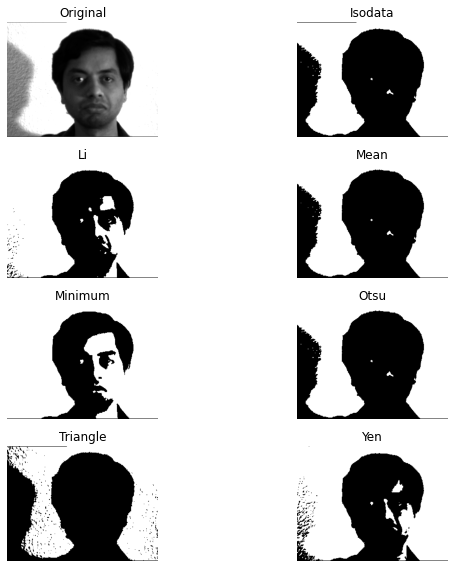

In [ ]:
plt.figure(figsize=(50, 50))
fig, a=try_all_threshold(image, figsize=(10, 8), verbose=False)   #Fonction qui essaie tous les types de binarisation (seuillage)
plt.show()

Après avoir analysé tous les types possibles de seuillage, on remarque que le seuillage `minimum` est celui qui préserve le plus les détails de l'image exemple qu'on a choisi, et donc on le choisira comme méthode de seuillage pour continuer notre étude (vu qu'on veut garder le maximum d'informations et en perdre le minimu voire pas du tout si c'est possible).

Text(0.5, 1.0, 'Image avec seuillage minimum')

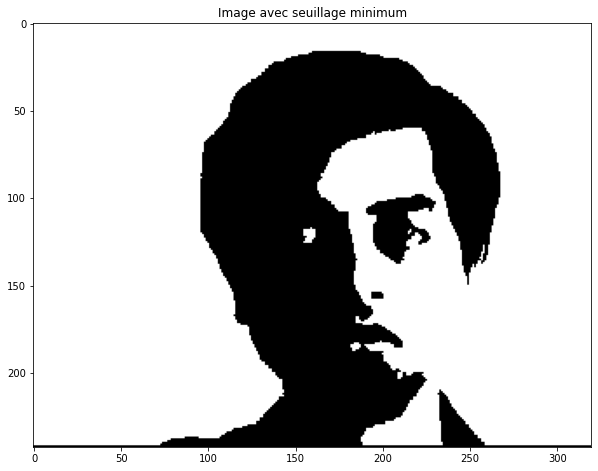

In [ ]:
plt.figure(figsize=(10, 10))

# Réaffirmation du choix du seuillage minimale et stockage de l'image szuillée dans une variable

thresh=filters.threshold_minimum(image)
seuil_image=image>thresh
plt.imshow(seuil_image, cmap='gray')
plt.title('Image avec seuillage minimum')

#### 2.2. Affichage des histogrammes d'apparition du noir :

Le **principe** de l'histogramme  des profils est de construire 2 histogrammes par lignes et par colonnes, ils contiennent respectivement le nombre de lignes et de colonnes sur l'axe des x, et sur les axes des Y ils contiennent le nombre des pixels noirs sur la ligne (colonne) concernée.</br>
Le but de ces 2 histogrammes est de repérer ou on peut couper l'image pour ne garder que ce qui nous intéresse dans la conception de notre système.

Histogramme de lignes :

In [ ]:
# Histogramme en lignes

hist_lines=[]
for i in range(image.shape[0]) :
    ligne=seuil_image[i,:]
    pixels_noirs=(ligne == 0).sum()
    hist_lines.append(pixels_noirs)

Histogramme de colonnes :

In [ ]:
# Histogramme en colonnes

hist_colonne=[]
for i in range(image.shape[1]) :
    colonne=seuil_image[:240,i]
    pixels_noirs=(colonne==0).sum()
    hist_colonne.append(pixels_noirs)

Visualisation des histogrammes :

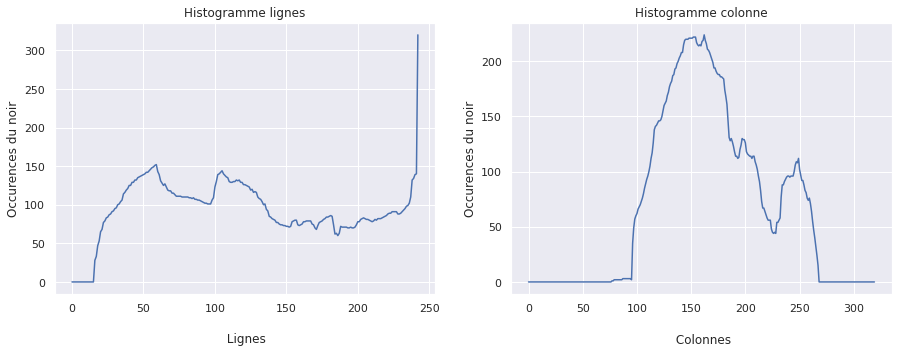

In [ ]:
# Les histogrammes des 2 profils (lignes et colonnes) et leurs affichages

sns.set()
fig=plt.figure(figsize=(15, 5))

fig.add_subplot(1, 2, 1)
plt.plot(np.array(range(image.shape[0])), hist_lines)
plt.ylabel('Occurences du noir')
plt.xlabel('\n Lignes')
plt.title("Histogramme lignes")

fig.add_subplot(1, 2, 2)
plt.plot(np.array(range(image.shape[1])), hist_colonne)
plt.xlabel('\n Colonnes')
plt.ylabel('Occurences du noir')
plt.title("Histogramme colonne")
plt.show()

#### 2.3. Choix de lignes et colonnes où on doit couper :

Après avoir créé l'histogramme des profils, ça va nous servir comme critère de choix pour dire ou on doit couper notre image pour garder le motif qu'on veut isoler. Le choix de la ligne ou on coupe se fait avec l'histogramme profil Lignes et de même pour les colonnes, les 2 au même-temps.

<b>Choix sur les lignes :</b><br>
Le choix a porté sur garder seulement les lignes à partir de l'apparition du noir jusqu'à sa disparition, on ne prend que les lignes qui ont des occurences non nulles en pixels noirs.<br>Le même critère est appliqué pour les colonnes.

In [ ]:
check=False
i=0
start_ligne=0
stop_ligne=len(hist_lines)
while ((i<len(hist_lines)) & (check==False)):
    if hist_lines[i]!=0:
        check=True
        start_ligne=i
    i+=1
check=False
i=start_ligne
while ((i<len(hist_lines)) & (check==False)):
    if hist_lines[i]>300:
        check=True
        stop_ligne=i
    i+=1

<b>Choix sur les colonnes :</b><br>
(Expliqué en haut).

In [ ]:
verif=False
j=0
start_colonne=0
stop_colonne=len(hist_colonne)
while ((j<len(hist_colonne)) & (verif==False)):
    if hist_colonne[j]>10:
        verif=True
        start_colonne=j
    else :
        verif=False
    j+=1
verif=False
j=start_colonne
while ((j < len(hist_colonne)) & (verif==False)):
    if (hist_colonne[j]==0) & (hist_colonne[j-5]==0):
        verif=True
        stop_colonne=j
    j+=1

### 2.4. Affichage du résultat :

Text(0.5, 1.0, 'Résultat du choix sur un exemple')

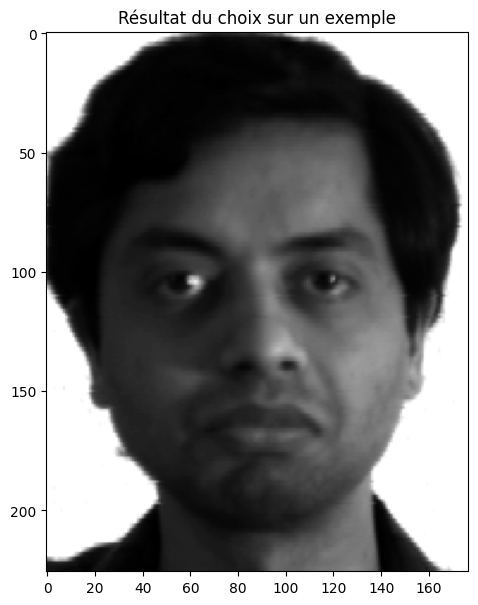

In [ ]:
plt.figure(figsize=(7, 7))

sns.reset_defaults()
plt.imshow(image[start_ligne:stop_ligne, start_colonne:stop_colonne], cmap='gray')
plt.title('Résultat du choix sur un exemple')

### Génarilisation à travers une fonction

In [ ]:
# Isoler les parties voulues de toutes les images à travers cette fonction

def histogramme_profil(img) :
    seuil=filters.threshold_minimum(img)
    thresholded_image=img>seuil
    hist_ligne=[]
    hist_colonne=[]
    for i in range(img.shape[0]) :
        ligne=thresholded_image[i,:]
        pixels_noirs=(ligne==0).sum()
        hist_ligne.append(pixels_noirs)
    for i in range(img.shape[1]) :
        colonne=thresholded_image[:,i]
        pixels_noirs=(colonne==0).sum()
        hist_colonne.append(pixels_noirs)

    start_ligne=0
    stop_ligne=len(hist_ligne)
    start_colonne=0
    stop_colonne=len(hist_colonne)
    check=False
    i=0
    while ((i<len(hist_ligne)) & (check==False)):
        if hist_ligne[i]!=0:
            check=True
            start_ligne=i
        i+=1
    check=False
    i=start_ligne
    while ((i<len(hist_ligne)) & (check==False)):
        if hist_ligne[i]>300:
            check=True
            stop_ligne=i
        i+=1
    start_colonne=0
    check=False
    j=0
    while ((j<len(hist_colonne)) & (check==False)):
        if hist_colonne[j]>10:
            check=True
            start_colonne=j
        else :
            check=False
        j+=1
    check=False
    j=start_colonne
    while ((j<len(hist_colonne)) & (check==False)):
        if (hist_colonne[j]==0) & (hist_colonne[j-1]==0) :
            check=True
            stop_colonne=j
        j+=1
    return img[start_ligne:stop_ligne, start_colonne:stop_colonne]

### Enregistrement des images résultantes dans un dossier :

In [ ]:
path="drive/MyDrive/data_colab/yalefaces/"
new_path="only_faces/"
for filename in os.listdir(path):
    name=path+filename
    img=io.imread(os.path.join(name), as_gray=True)
    visage_seul=histogramme_profil(img)
    cv.imwrite(new_path+filename+'.jpg', visage_seul)

Toutes les images, sauf une, étaient bien traitées après avoir utilisé cette fonction. En conséquence, elle a nécessité un traitement particulier à elle seule en ce qui suit.

In [ ]:
image01=io.imread(os.path.join("drive/MyDrive/data_colab/yalefaces/subject12.rightlight.gif"), as_gray = True)

Text(0.5, 1.0, "Image après l'application de l'histogramme de profil")

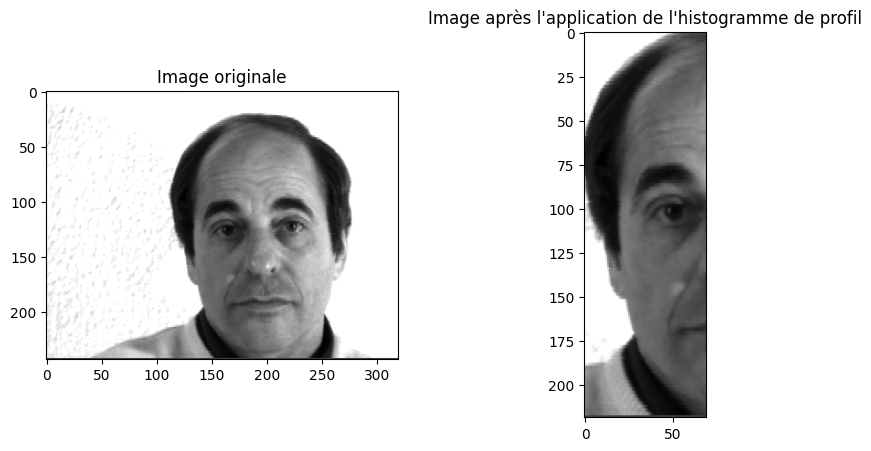

In [ ]:
# Visualisation du problème pour cette image à cause du seuillage choisi

figure=plt.figure(figsize=(10, 5))
figure.add_subplot(1,2,1)
plt.imshow(image01, cmap='gray')
plt.title('Image originale')
figure.add_subplot(1,2,2)
plt.imshow(histogramme_profil(image01), cmap='gray')
plt.title("Image après l'application de l'histogramme de profil")
# En conclusion, le seuillage minimum n'a pas marché pour cette image; d'ou la necessité de choisir un autre seuillage

<Figure size 2000x2000 with 0 Axes>

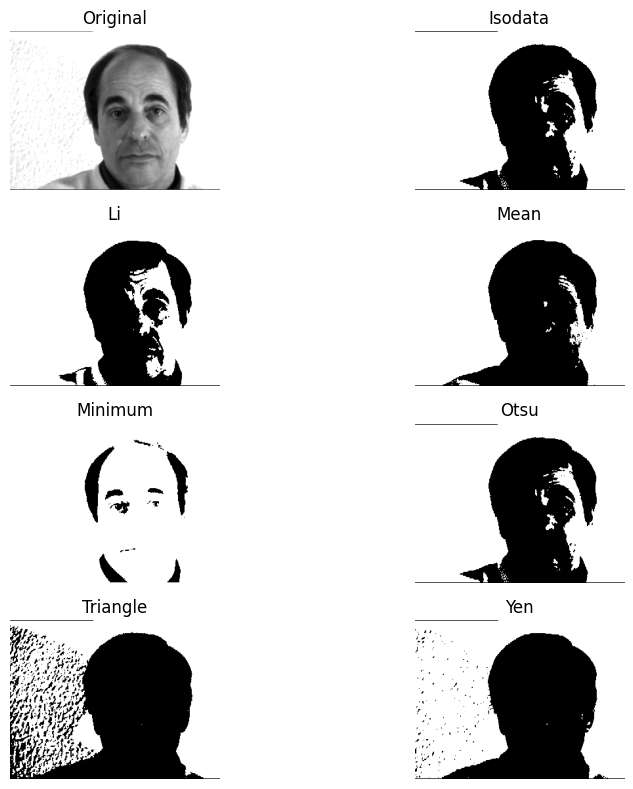

In [ ]:
plt.figure(figsize=(20, 20))

# Réexamen de tous les suillages disponibles et voir lequel donne le meilleur résultat pour cette image en particulier
fig, a=try_all_threshold(image01, figsize=(10, 8), verbose=False)
plt.show()

On remarque que c'est le seuillage Otsu qui donne le meilleur résultat pour cette image en particulier après le résultat du seuillage minimum.

Text(0.5, 1.0, 'Image sueillée par Otsu')

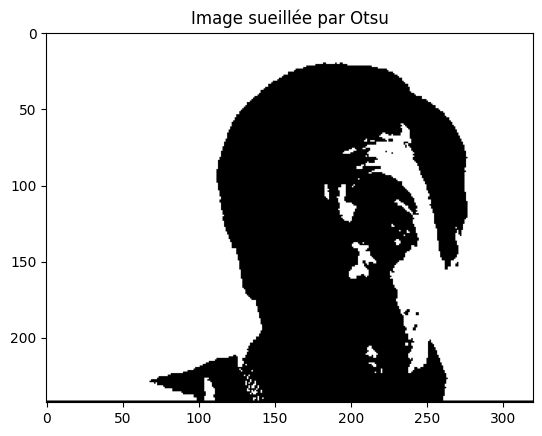

In [ ]:
thresh=threshold_otsu(image01)
plt.imshow(image01>thresh, cmap='gray')
plt.title('Image sueillée par Otsu')

Adaptation de la fonction pour cette image :

In [ ]:
# Construction des histogrammes des profils lignes et colonnes pour cette image en particulier (ça necessite quelques modifications)

def histogramme_profil(img) :
    thresh=threshold_otsu(img)
    thresholded_image=img>thresh
    hist_ligne=[]
    hist_colonne=[]
    for i in range(img.shape[0]) :
        ligne=thresholded_image[i,:]
        pixels_noirs=(ligne==0).sum()
        hist_ligne.append(pixels_noirs)
    for i in range(img.shape[1]) :
        colonne=thresholded_image[:,i]
        pixels_noirs=(colonne==0).sum()
        hist_colonne.append(pixels_noirs)

    start_ligne=0
    stop_ligne=len(hist_ligne)
    start_colonne=0
    stop_colonne=len(hist_colonne)
    check=False
    i=0
    while ((i<len(hist_ligne)) & (check==False)):
        if hist_ligne[i]!=0:
            check=True
            start_ligne=i
        i+=1
    check=False
    i=start_ligne
    while ((i<len(hist_ligne)) & (check==False)):
        if hist_ligne[i]>300:
            check=True
            stop_ligne=i
        i+=1
    start_colonne=0
    check=False
    j=0
    while ((j<len(hist_colonne)) & (check==False)):
        if hist_colonne[j]>10:
            check=True
            start_colonne=j
        else :
            check=False
        j+=1
    check=False
    j=start_colonne
    while ((j<len(hist_colonne)) & (check==False)):
        if (hist_colonne[j]==0) & (hist_colonne[j-1]==0) :
            check=True
            stop_colonne=j
        j+=1
    return img[start_ligne:stop_ligne, start_colonne:stop_colonne]

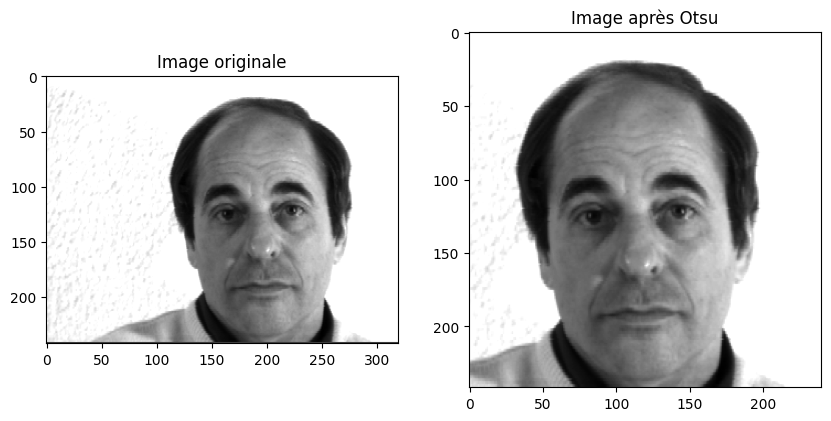

In [ ]:
fig=plt.figure(figsize=(10, 10))

# Affichage de la nouvelle image souillée et coupée
fig.add_subplot(1,2,1)
plt.imshow(image01, cmap='gray')
plt.title('Image originale')
fig.add_subplot(1,2,2)
plt.imshow(histogramme_profil(image01), cmap='gray')
plt.title('Image après Otsu')
plt.show()

In [ ]:
cv.imwrite("drive/MyDrive/data_colab/yalefaces/only_faces/subject12.rightlight.gif"+'.jpg', histogramme_profil(image01))

True

### Redimensionnement des images :

In [ ]:
images=[]
names=[]
path="drive/MyDrive/data_colab/yalefaces/only_faces/"
for filename in os.listdir(path):
    name=path+filename
    names.append(filename)
    image=io.imread(os.path.join(name), as_gray=True)
    images.append(cv.resize(image,(242 , 320)))     # On utilise l'interpolation par défaut de la fonction resize()

Je les ai enregistré dans un nouveau dossier.

In [ ]:
for i in range(len(images)):
    image=images[i]
    name=names[i]
    cv.imwrite("drive/MyDrive/data_colab/yalefaces/only_faces/"+name, image)

## 3. Création des 15 dossiers, où chaque dossier contient 11 images de chaque personne :

In [ ]:
for i in range(len(images)):
    name=names[i]
    image=images[i]
    for number in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']:
        if number in name :
            cv.imwrite("person"+number+"/"+name, image)

# IV. Génération de caractéristiques :

## 4. Génération des histogrammes de gradient :

### 4.1. Importation des images qui contiennent que les visages :

Création d'une fonction qui importe des images d'un dossier et les stocke dans une liste.

In [ ]:
def load_from_folder(folder):
    images=[]
    for filename in os.listdir(folder):
        img=io.imread(os.path.join(folder,filename), as_gray = True)
        images.append(img)
    return images

In [ ]:
subject1=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject01")
subject2=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject02")
subject3=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject03")
subject4=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject04")
subject5=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject05")
subject6=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject06")
subject7=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject16")
subject8=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject08")
subject9=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject09")
subject10=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject10")
subject11=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject11")
subject12=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject12")
subject13=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject13")
subject14=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject14")
subject15=load_from_folder("drive/MyDrive/data_colab/yalefaces/subject15")

### 4.2. Essai de l'histogramme des gradients orientés sur une image :

In [ ]:
fv, hog_image=hog(subject2[0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)

Text(0.5, 1.0, "Histogramme de gradient de l'image")

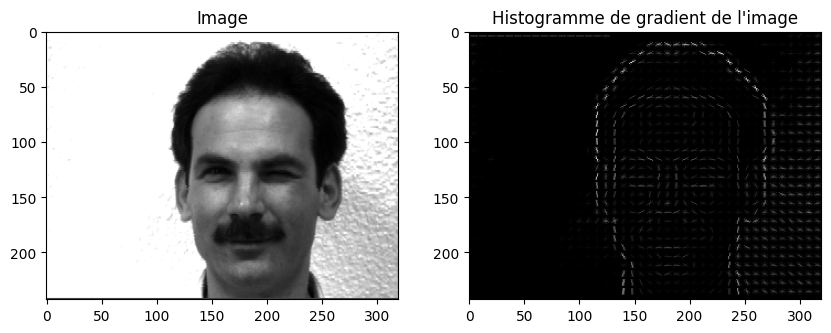

In [ ]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.imshow(subject2[0], cmap='gray')
plt.title('Image')
fig.add_subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title("Histogramme de gradient de l'image")

### 4.3. Application de l'histogramme de gradient sur toutes les images :

In [ ]:
subjects = [subject1, subject2, subject3, subject4, subject5, subject6, subject7, subject8, subject9, subject10, subject11, subject12, subject13, subject14, subject15]
fvs = []
for subject in subjects:
    for i in range(11):
        fvs.append(hog(subject[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)[0])

IndexError: ignored

In [ ]:
# Zonage de l'image

fv1 = fvs[:11]
fv2 = fvs[11:22]
fv3 = fvs[22:33]
fv4 = fvs[33:44]
fv5 = fvs[44:55]
fv6 = fvs[55:66]
fv7 = fvs[66:77]
fv8 = fvs[77:88]
fv9 = fvs[88:99]
fv10 = fvs[99:110]
fv11 = fvs[110:121]
fv12 = fvs[121:132]
fv13 = fvs[132:143]
fv14 = fvs[143:154]
fv15 = fvs[154:165]

## 5. Séparation des ensembles apprentissage/test :
Nous avons procédé par une séparataion pour chaque personne et ensuite à un groupement.<br>
7 images pour l'apprentissage et 4 pour le test.

In [ ]:
fv_list = [fv1, fv2, fv3, fv4, fv5, fv6, fv7, fv8, fv9, fv10, fv11, fv12, fv13, fv14, fv15]
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(15):
    fv = fv_list[i]
    train, test = train_test_split(fv, test_size=5/11, random_state=42)
    for j in range(6z):
        x_train.append(train[j])
    for j in range(5):
        x_test.append(test[j])
    for j in range(6):
        y_train.append(i+1)
    for j in range(5):
        y_test.append(i+1)

IndexError: ignored

Maintenant, les ensembles test et train (apprentissage) sont organisés (7 ou 4 lignes de personne 1 puis 7 ou 4 lignes de la personne 2 et ainsi de suite).<br>
Nous avons procédé à une randomisation pour fiabiliser le résultat

In [ ]:
train=list(zip(x_train, y_train))
random.shuffle(train)
x_train,y_train=zip(*train)

test=list(zip(x_test, y_test))
random.shuffle(test)
x_test, y_test=zip(*test)

# V. Classification :

## 6. Application de l'algorithme `K-plus proches voisins` :

### 6.1. Essai de plusieurs distances et plusieurs valeurs de K :

In [ ]:
metrics=["euclidean", "manhattan", "canberra"]
k_s=[1, 3, 5, 7, 9]
for k in k_s:
    for metric in metrics:
        knn_model=KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn_model.fit(x_train, y_train)
        score=np.round(accuracy_score(y_test, knn_model.predict(x_test)),2)
        print(f"La précision pour k={k} et la distance {metric}: {score}")

La précision pour k=1 et la distance euclidean: 0.56
La précision pour k=1 et la distance manhattan: 0.56
La précision pour k=1 et la distance canberra: 0.5
La précision pour k=3 et la distance euclidean: 0.52
La précision pour k=3 et la distance manhattan: 0.5
La précision pour k=3 et la distance canberra: 0.46
La précision pour k=5 et la distance euclidean: 0.48
La précision pour k=5 et la distance manhattan: 0.44
La précision pour k=5 et la distance canberra: 0.46
La précision pour k=7 et la distance euclidean: 0.42
La précision pour k=7 et la distance manhattan: 0.42
La précision pour k=7 et la distance canberra: 0.37
La précision pour k=9 et la distance euclidean: 0.38
La précision pour k=9 et la distance manhattan: 0.4
La précision pour k=9 et la distance canberra: 0.33


Le meilleur résultat est dans le cas de `k=1` et `distance euclidienne`

### 6.2. Application du meilleur modèle :

In [ ]:
best_knn_model=KNeighborsClassifier(n_neighbors=1, metric="euclidean")

In [ ]:
best_knn_model.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [ ]:
y_pred=best_knn_model.predict(x_test)

### 6.3. Affichage des résultats :

In [ ]:
print('                Rapport de la classification :\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']))

                Rapport de la classification :



ValueError: ignored

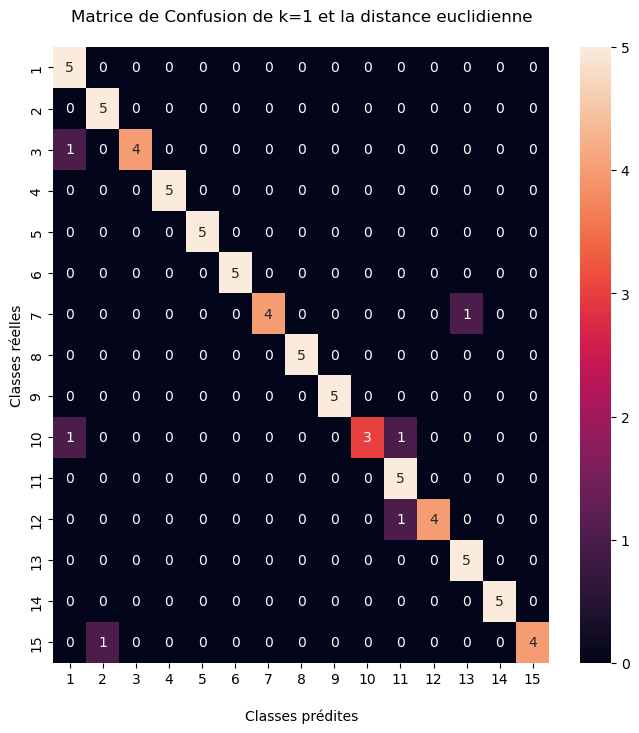

In [ ]:
figure=plt.figure(figsize=(8,8))
ax=sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_title('Matrice de Confusion de k=1 et la distance euclidienne\n');
ax.set_xlabel('\nClasses prédites')
ax.set_ylabel('Classes réelles');

ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])

plt.show()

## 7. Application d'un `réseau de neurones multicouches` :

### 7.1. Essai de plusieurs nombres de neurones dans la couche cachée et plusieurs valeurs de alpha :

In [ ]:
neurones = [3, 10, 20, 50]
alpha_list = [0, 0.1, 0.01]
for nombre in neurones:
    for alpha in alpha_list :
        mlp_model = MLPClassifier(hidden_layer_sizes=(nombre,), activation='logistic', alpha=alpha, random_state=42)
        mlp_model.fit(x_train, y_train)
        score = np.round(accuracy_score(y_test, mlp_model.predict(x_test)),2)
        print(f"La précision pour {nombre} neurones et alpha={alpha}: {score}")

La précision pour 3 neurones et alpha=0: 0.39
La précision pour 3 neurones et alpha=0.1: 0.41
La précision pour 3 neurones et alpha=0.01: 0.39
La précision pour 10 neurones et alpha=0: 0.89
La précision pour 10 neurones et alpha=0.1: 0.95
La précision pour 10 neurones et alpha=0.01: 0.89
La précision pour 20 neurones et alpha=0: 0.97
La précision pour 20 neurones et alpha=0.1: 0.97
La précision pour 20 neurones et alpha=0.01: 0.97
La précision pour 50 neurones et alpha=0: 0.93
La précision pour 50 neurones et alpha=0.1: 0.95
La précision pour 50 neurones et alpha=0.01: 0.93


Le meilleur résultat était avec 20 neurones et alpha=0.1.

### 7.2. Application du meilleur modèle :

In [ ]:
best_mlp_model = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', alpha=0.1, random_state=42)

In [ ]:
best_mlp_model.fit(x_train, y_train)

MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(20,),
              random_state=42)

In [ ]:
y_pred = best_mlp_model.predict(x_test)

### 7.3. Affichage des résultats :

In [ ]:
print('                Rapport de la classification :\n')
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']))

                Rapport de la classification :

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      0.60      0.75         5
          11       0.71      1.00      0.83         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5

    accuracy                           0.97        75
   macro avg       0.98      0.9

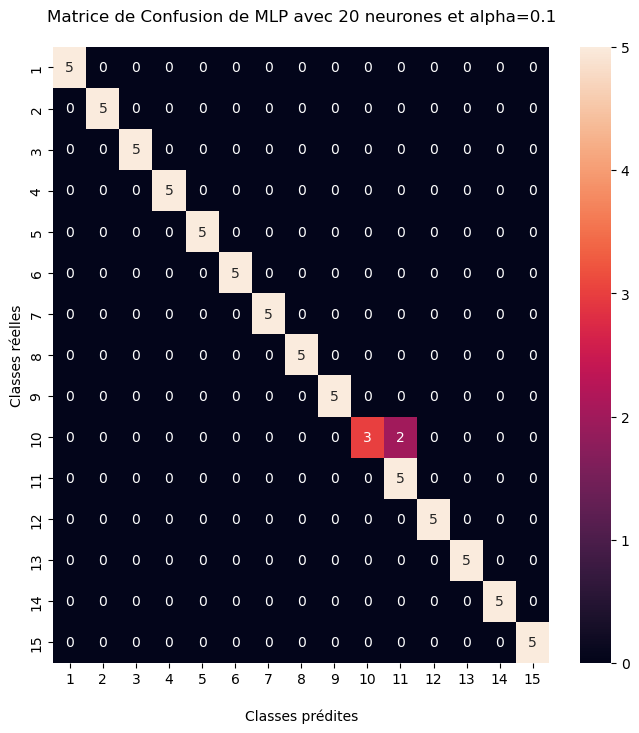

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
ax.set_title('Matrice de Confusion de MLP avec 20 neurones et alpha=0.1\n');
ax.set_xlabel('\nClasses prédites')
ax.set_ylabel('Classes réelles');

ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])

plt.show()

## 8. Comparaison entre les deux méthodes :
Nous observons que la méthode du réseau de neurones multicouches est <b>largement</b> plus performante, elle a donné 97% de précision contrairement à k-plus proches voisins qui a fourni une précision de 92 %.

## 9. Les images mal classées :
On a 2 images de la personne 10 qui ont été classées avec la personne 11.

### 9.1. Détection des images mal classées :
`y_test = 10` et `y_pred = 11`

In [ ]:
faux=[]
for i in range(75) :
    if (y_test[i]==10) & (y_pred[i]==11) :
        faux.append(i)
faux

[32, 65]

In [ ]:
faux = []
for i in range(11):
    fv = hog(subject10[i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)[0]
    if (fv == x_test[32]).sum() == 40716 :
        faux.append(i)
    if (fv == x_test[65]).sum() == 40716 :
        faux.append(i)
faux

[2, 5]

### 9.2. Affichage des images mal classées avec une image de la personne 11 :

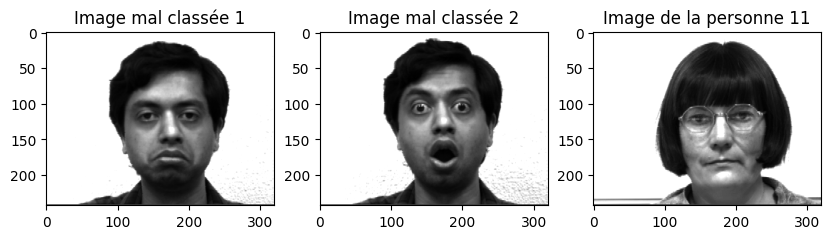

In [ ]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(1,3,1)
plt.imshow(subject10[2], cmap='gray')
plt.title("Image mal classée 1")
fig.add_subplot(1,3,2)
plt.imshow(subject10[5], cmap='gray')
plt.title("Image mal classée 2")
fig.add_subplot(1,3,3)
plt.imshow(subject11[5], cmap='gray')
plt.title("Image de la personne 11")
plt.show()

On voit que les 2 personnes ont la meme forme de cheveux.<br>
Je pense que c'est la raison pour laquelle les images étaient mal classées.

## 10. Propositions d'amélioration :
- Proposition d'élargir la base de données en rajoutant d'autres images pour chaque personne.
- Proposition de changer le descripteur utilisé.
- Proposition de changer le zonage de l'image lors du calcul de l'histogramme des gradients orientés.
- Nous pouvons aussi proposer de changer l'algotithme d'apprentissage notamment dans les réseaux de neurones multicouches, on peut y changer la fonction d'activation d'un neurone.
- Suggestion d'essayer de ne conserver que le visage et non les cheveux pour plus de précision.